# Linear Regression

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
plt.style.use('seaborn')
sns.set(rc={'figure.figsize':(15, 8)})
from sklearn.linear_model import LinearRegression

#ignore future warnings that occur when running lasso/ridge regresssion
#makes output cleaner
import warnings
from warnings import filterwarnings
filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

## Load Dataset

In [6]:
training_data = pd.read_csv("./Dataset/train.csv")
training_data.tail()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[5 rows x 81 columns]

In [7]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
#Description of features 
data_desc_path = './Dataset/data_description.txt'
with open(data_desc_path, 'r') as file:
    data_desc = file.read()
print(data_desc)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

## EDA (Exploratory Data Analysis)

First, we will see the amount of missing data in each column and drop those that have too many to the point where it isn't meaningful to analyze them.

In [9]:
#List features with over 25% missing data

nan_mean = training_data.isna().mean() * 100
nan      = nan_mean[nan_mean > 25].sort_values(ascending = False)

print("Columns with missing values above 25%:")
print(nan)

Columns with missing values above 25%:
PoolQC         99.520548
MiscFeature    96.301370
Alley          93.767123
Fence          80.753425
MasVnrType     59.726027
FireplaceQu    47.260274
dtype: float64


In [10]:
#Remove features with over 25% missing values

def remove_excess_missing(data, upper_limit = 25):
    #purpose: remove features with too many missing values
    
    nan_mean = data.isna().mean()*100
    nan = nan_mean[nan_mean > upper_limit].sort_values(ascending = False)
    
    return data.drop(columns = nan.index)

training_data = remove_excess_missing(training_data,25)

The joint plot was made to see if there are outliers. There are outliers present when the sales price is large and where the living area is greater than 500 sq. ft.

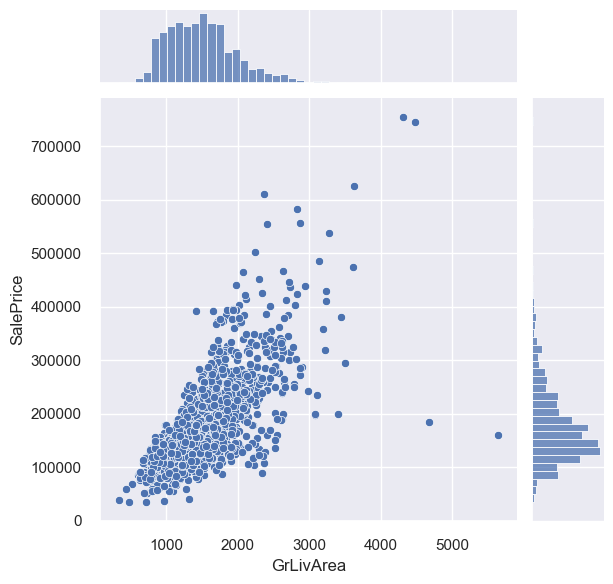

In [11]:
#outliers seen from ground living area vs sales price plot

training_data.columns.values

sns.jointplot(
    x = 'GrLivArea', 
    y = 'SalePrice', 
    data = training_data,
);

Outliers exists when the GrLivArea is greater than 5,000 because they were partial sales (Low SalePrice). 
Therefore, it is in our interest to remove the outliers so our model can fit more accurately.

In [12]:
#check for outliers in the data

training_data.loc[training_data['GrLivArea'] > 4000, ['GrLivArea', 'SalePrice']]

GrLivArea  SalePrice
523        4676     184750
691        4316     755000
1182       4476     745000
1298       5642     160000

In [13]:
def remove_outliers(data, variable, upper):
    #purpose: remove outliers from a dataset given a certain feature and upper limit
    
    return data.loc[(data[variable] < upper), :]

training_data = remove_outliers(training_data, 'GrLivArea', 4000)

The correlation between the Sales Price and the numerical variables will help determine which variables to choose 
One thing to keep in mind is colinearity within the data. This will be addressed later in the notebook.

In [101]:
#type of variables for features in data
training_data.dtypes.value_counts()

object     37
int64      35
float64     3
Name: count, dtype: int64

Text(0, 0.5, 'Feature')

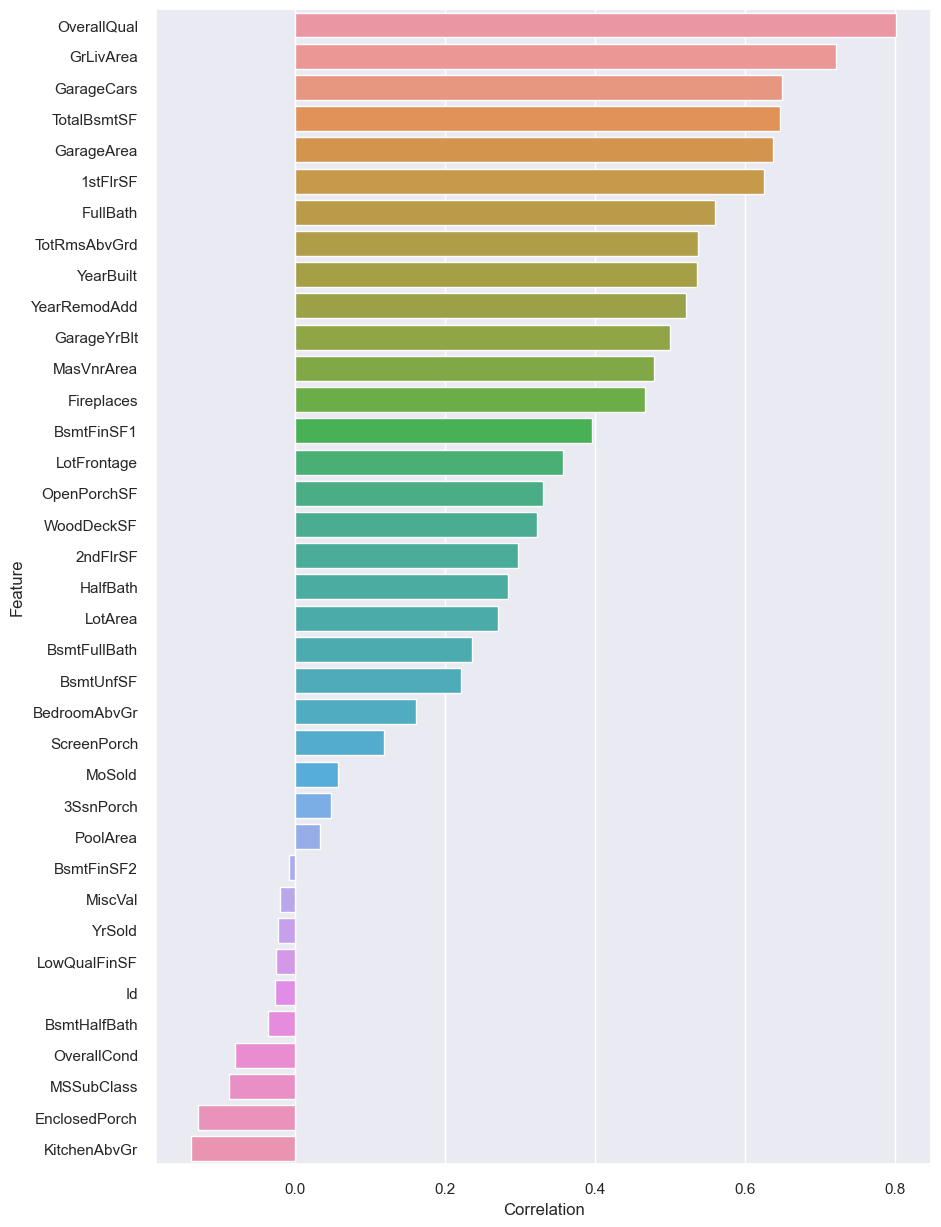

In [102]:
#find features that are numerical variables
num_cols = training_data.dtypes[(training_data.dtypes == 'int64') | (training_data.dtypes == 'float64')].index
corr_df = training_data.loc[:,num_cols].corr()

#plot the correlation between each numerical variable and sales price and sort them
sale_price_corr = corr_df['SalePrice'].drop('SalePrice',axis = 0).sort_values(ascending = False)
ax = plt.subplots(figsize = (10, 15))
ax = sns.barplot(y = sale_price_corr.keys(), x = sale_price_corr.values)
plt.xlabel("Correlation")
plt.ylabel("Feature")

#### Intuitively, one can expect that if there are more bedrooms, the sale price will be higher. 
#### However, from creating a scatter plot, there doesn't seem to be a clear correlation.

<Axes: xlabel='BedroomAbvGr', ylabel='SalePrice'>

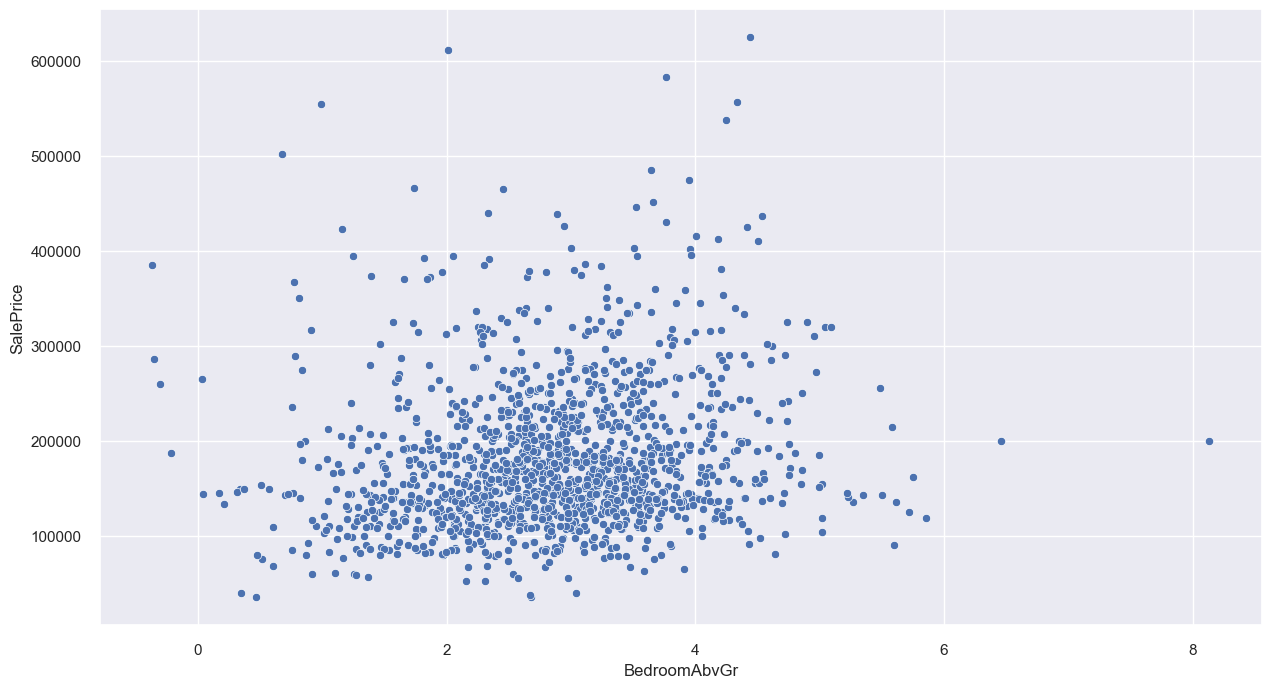

In [104]:
#checking for correlation between number of bedrooms and sales price

noise = np.random.normal(0,0.5,training_data.shape[0])
training_data_2 = training_data
training_data_2['BedroomAbvGr'] = training_data_2['BedroomAbvGr'] + noise
sns.scatterplot(data = training_data_2,x = 'BedroomAbvGr',y = 'SalePrice')

#### The overall quality of the house (rated 1-10) seemed to have the highest correlation. Let's see how the scatter plot looks like.

<Axes: xlabel='OverallQual', ylabel='SalePrice'>

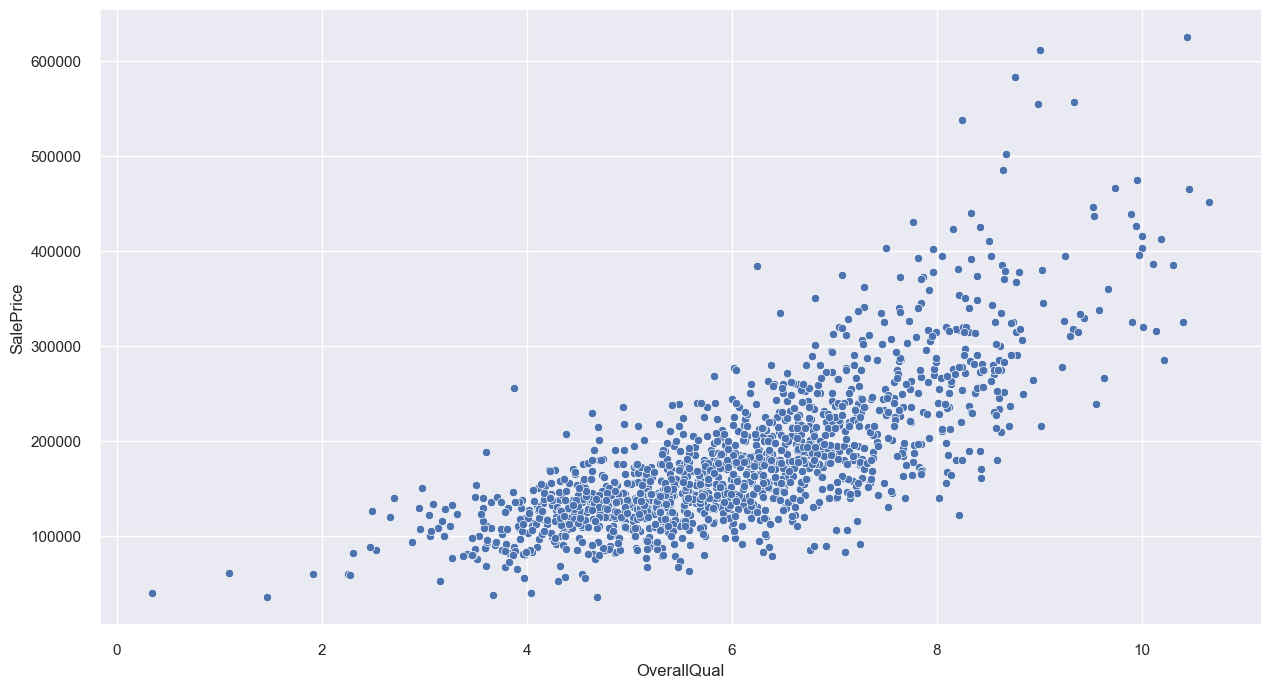

In [106]:
#checking for correlation between overall quality of house and sales price

training_data_2 = training_data
training_data_2['OverallQual'] = training_data_2['OverallQual'] + noise
sns.scatterplot(data = training_data_2, x = 'OverallQual', y = 'SalePrice')

Text(0, 0.5, 'Frequency')

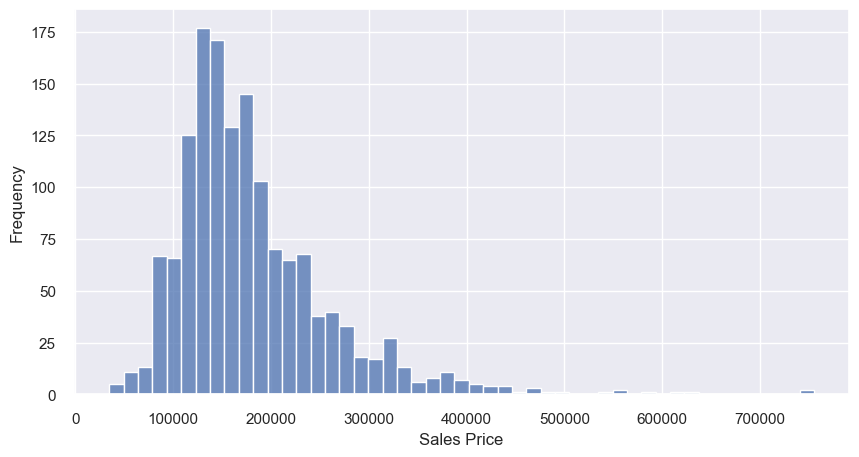

In [96]:
#distribution of sales price

plt.figure(figsize=(10,5))
sns.histplot(training_data, x='SalePrice')
plt.xlabel("Sales Price")
plt.ylabel("Frequency")

In [1]:
#histogram of neighborhoods 

training_data.groupby('Neighborhood').size().sort_values(ascending=False).plot(kind='bar')

NameError: name 'training_data' is not defined

### List column with nulls

In [51]:
null_cols = df_train.columns[df_train.isnull().any()].tolist()
null_info = df_train[null_cols].dtypes.reset_index()
null_info.columns = ['Column with Nulls','DType']
null_info

Column with Nulls    DType
0        LotFrontage  float64
1              Alley   object
2         MasVnrType   object
3         MasVnrArea  float64
4           BsmtQual   object
5           BsmtCond   object
6       BsmtExposure   object
7       BsmtFinType1   object
8       BsmtFinType2   object
9         Electrical   object
10       FireplaceQu   object
11        GarageType   object
12       GarageYrBlt  float64
13      GarageFinish   object
14        GarageQual   object
15        GarageCond   object
16            PoolQC   object
17             Fence   object
18       MiscFeature   object

### Checking numeric columns: LotFrontage, MasVnrArea, GarageYrBlt

In [50]:
mean = round(df_train['LotFrontage'].mean(),1)
median = df_train['LotFrontage'].median()
mode = df_train['LotFrontage'].mode()[0]

print('Mean   LotFrontage:', mean)
print('Median LotFrontage:', median)
print('Mode   LotFrontage:', mode)

Mean  : 70.0
Median: 69.0
Mode  : 60.0


### Melihat nilai Mean, Median dan Mode, disimpulkan LotFrontage memiliki distribusi normal dan yang null bisa kita isi dengan nilai Mean

In [54]:
df_train['LotFrontage'].fillna(mean, inplace=True)

In [55]:
mean = round(df_train['MasVnrArea'].mean(),1)
median = df_train['MasVnrArea'].median()
mode = df_train['MasVnrArea'].mode()[0]

print('Mean   MasVnrArea:', mean)
print('Median MasVnrArea:', median)
print('Mode   MasVnrArea:', mode)

Mean   MasVnrArea: 103.7
Median MasVnrArea: 0.0
Mode   MasVnrArea: 0.0


In [57]:
filtered_df = df_train[df_train['MasVnrArea'] == 0]

unique_combi = filtered_df[['MasVnrArea','MasVnrType']].drop_duplicates()
print(unique_combi)

      MasVnrArea MasVnrType
1            0.0        NaN
688          0.0    BrkFace
1241         0.0      Stone


### Ternyata yang Mansory Veneer Area nya = 0 maka Mansory Veneer Type nya Null, untuk kasus seperti ini kita update nilai Mansory Veneer Type menjadi 'None' mengikuti guidance dari data_description.txt

In [58]:
df_train['MasVnrType'].fillna('None', inplace=True)

### Check Garage Year Built

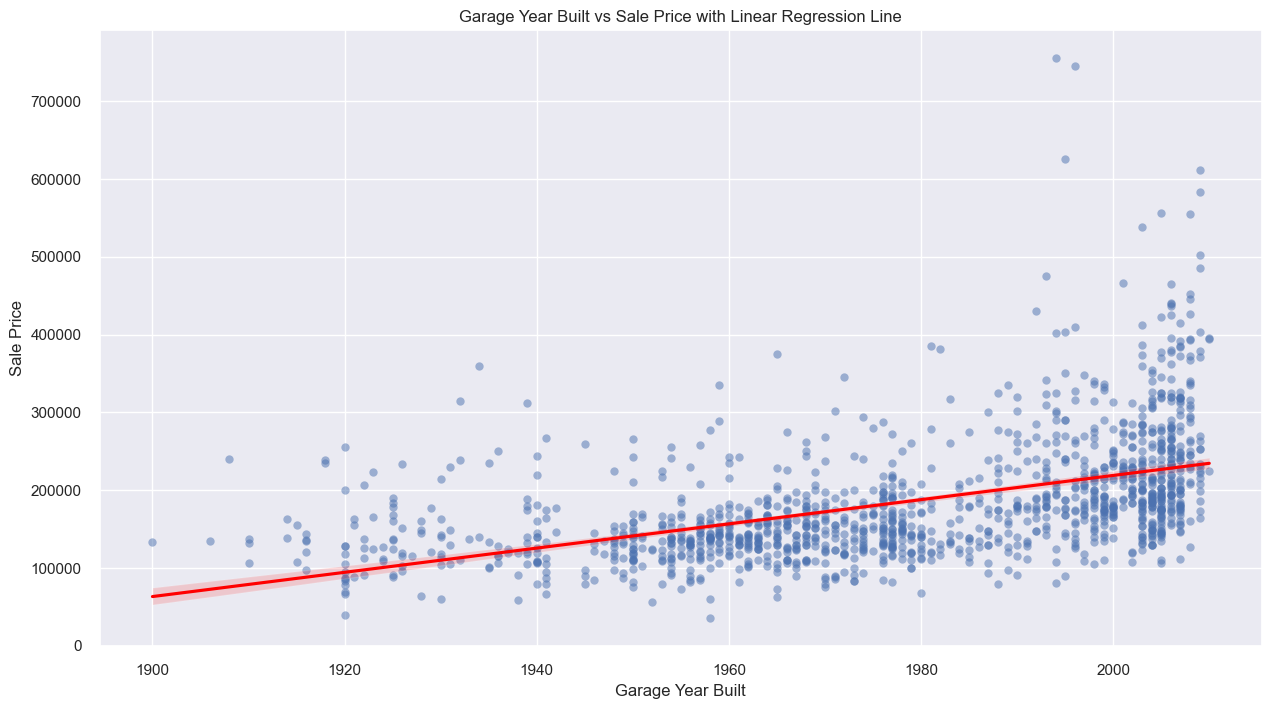

In [76]:
sns.regplot(x='GarageYrBlt', y='SalePrice', data=df_train, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Garage Year Built vs Sale Price with Linear Regression Line')
plt.xlabel('Garage Year Built')
plt.ylabel('Sale Price')
plt.show()

In [75]:
df_train['GarageYrBlt'].interpolate(method='cubic')

0       2003.0
1       1976.0
2       2001.0
3       1998.0
4       2000.0
         ...  
1455    1999.0
1456    1978.0
1457    1941.0
1458    1950.0
1459    1965.0
Name: GarageYrBlt, Length: 1460, dtype: float64

In [29]:
df_train.tail()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[5 rows x 81 columns]

## Explore & Visualize Data

In [6]:
print('Total rows:', df_train.shape[0])
print('Total features:', df_train.shape[1])

Total rows: 1460
Total features: 81


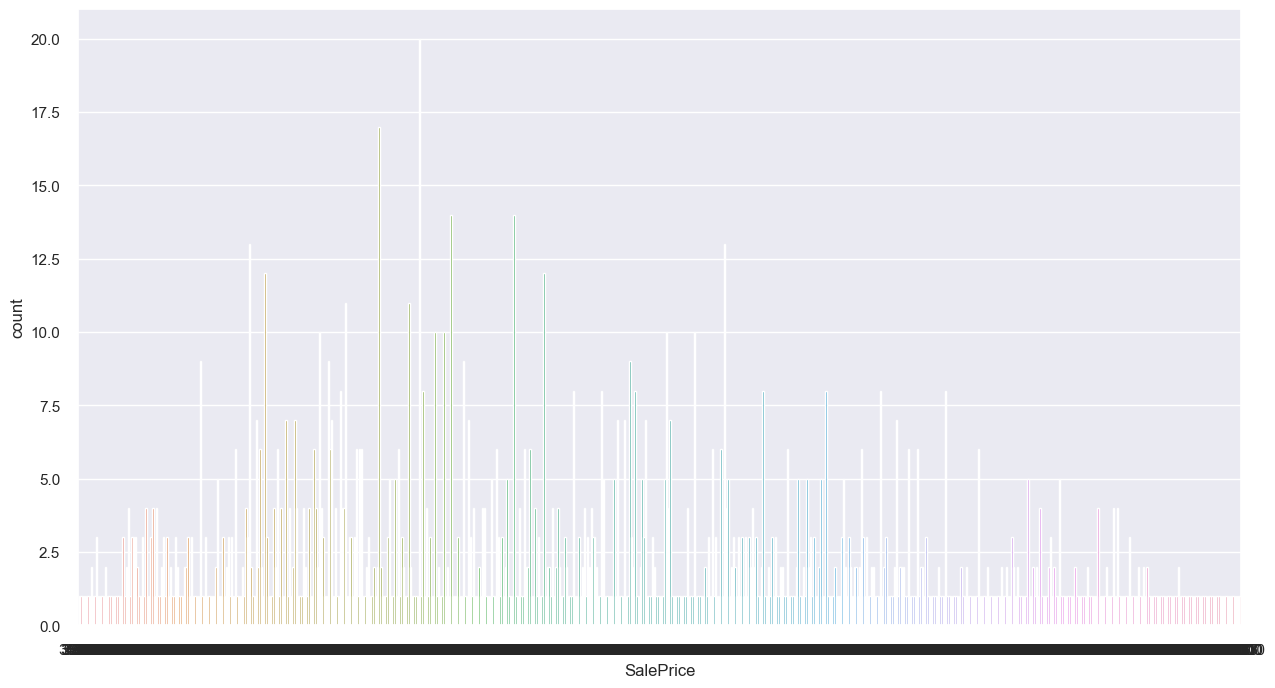

In [11]:
# Assuming 'y' is the column you want to visualize in the 'x' axis and 'df_train' is your DataFrame
sns.countplot(x='SalePrice', data=df_train)

plt.show()

In [12]:
df_train['SalePrice'].value_counts()

SalePrice
140000    20
135000    17
155000    14
145000    14
190000    13
          ..
202665     1
164900     1
208300     1
181500     1
147500     1
Name: count, Length: 663, dtype: int64

In [16]:
df_train.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

#### Check Neighborhood Feature

In [21]:
np.unique(df_train['Neighborhood'])

array(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
       'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
       'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown',
       'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
       'Veenker'], dtype=object)

In [22]:
df_train.groupby('Neighborhood')

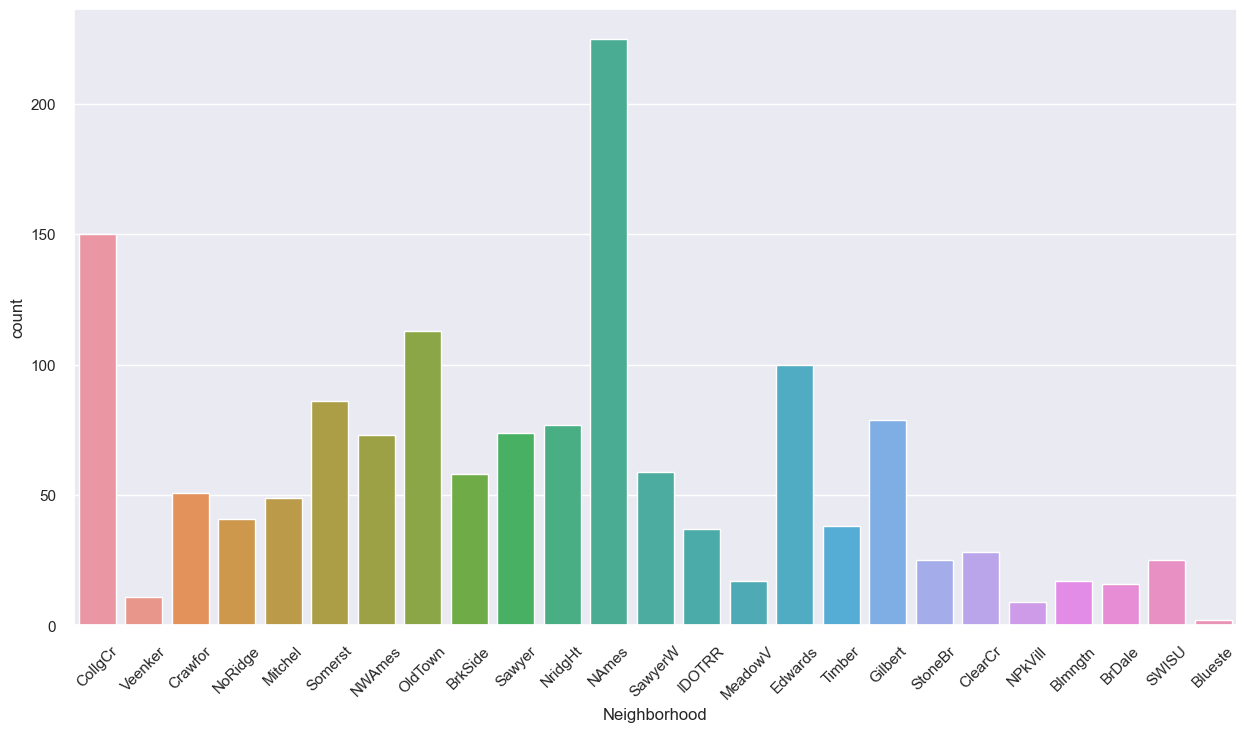

<Figure size 2000x2000 with 0 Axes>

In [25]:
sns.countplot(x='Neighborhood', data=df_train)
plt.xticks(rotation=45)
plt.figure(figsize=(20, 20))
plt.show()

#### Check LotArea

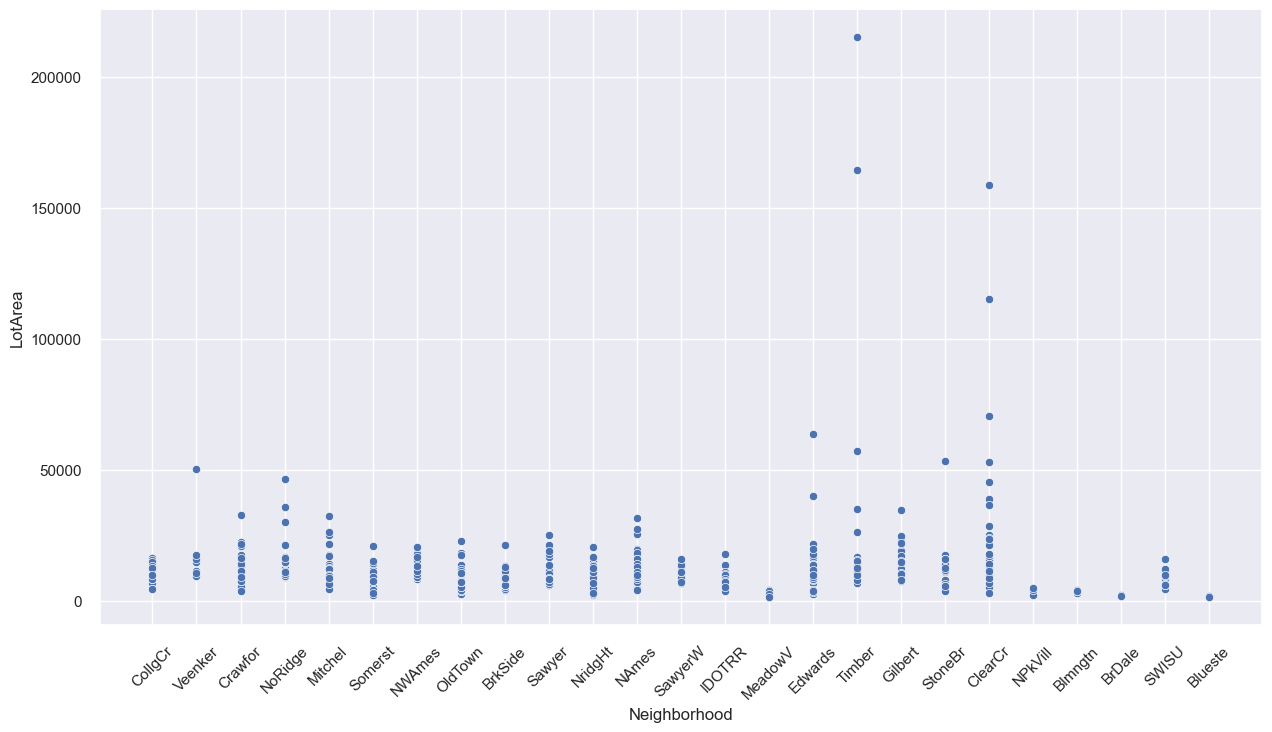

In [26]:
sns.scatterplot(x='Neighborhood', y='LotArea', data=df_train)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Display the plot
plt.show()